In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
#import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)


from numba import jit
from data import priors
from data.data import enhance_contrast, add_counting_noise, forward_model
from deep_bayes.models import BayesFlow, SequenceNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior
tf.keras.backend.set_floatx('float64')

In [2]:
param_names = priors.rh_names + priors.th_names 
theta_dim = len(param_names)

# Network hyperparameters
inv_meta = {
    'n_units': [256, 256, 256],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 6


summary_meta = {
    'lstm_units' :  96,
    'conv_meta'  : [
            dict(filters=64, kernel_size=5, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
    ],
}

ckpt_file = "SEIDR_learn_rho_E0"

global_step = tf.Variable(0, dtype=tf.int32)

decay_steps = 1000
decay_rate = .99
starter_learning_rate = 0.0005
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

summary_net = SequenceNetwork(summary_meta)
print("theta_dim", theta_dim)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("No model found! initializing from scratch")

theta_dim 13
Restored from ./checkpoints/SEIDR_learn_rho_E0/ckpt-15


In [3]:
from data.data import load_country

N = 60*1e6
S,I,D,R = load_country(N, "Italy")

data_x = np.stack([S,I,D,R]).T

data = enhance_contrast(data_x[None,:,:])

print("S", S)
print("I", I)
print("D", D)
print("R", R)

S [60000000. 59999998. 59999998. 59999998. 59999998. 59999998. 59999998.
 59999998. 59999997. 59999997. 59999997. 59999997. 59999997. 59999997.
 59999997. 59999997. 59999997. 59999997. 59999997. 59999997. 59999997.
 59999997. 59999979. 59999935. 59999840. 59999763. 59999667. 59999532.
 59999283. 59999045. 59998797. 59998189. 59997763. 59997259. 59996528.
 59995580. 59994644. 59993295. 59991637. 59989641. 59988496. 59985666.
 59985666. 59979635. 59975436. 59971109. 59967113. 59963050. 59957284.
 59951120. 59944507. 59935525. 59928362. 59922972. 59915678. 59908749.
 59900835. 59893418. 59885121. 59878502.]
I [    0     2     2     2     2     2     2     2     3     3     3     3
     3     3     3     3     3     3     3     3     3     3    20    62
   155   229   322   453   655   888  1128  1694  2036  2502  3089  3858
  4636  5883  7375  9172 10149 12462 12462 17660 21157 24747 27980 31506
 35713 41035 47021 53578 59138 63927 69176 74386 80589 86498 92472 97689]
D [    0     0     0

In [4]:
theta_hat_e = model.sample(data, 500, to_numpy=True)
theta_hat = theta_hat_e.copy()

# restore original rho and rho_t parameters
from deep_bayes import theta as thetaed
theta_hat[:,0:7] = thetaed.decode(theta_hat[:,0:7], priors.rh_low, priors.rh_high)
theta_hat[:,3:7] = theta_hat[:,3:7] / np.sum(theta_hat[:,3:7], axis=1, keepdims = True)
theta_hat[:,3:7] = np.cumsum((theta_hat[:,3:7]),axis=1)*S.shape[0]
theta_hat[:,7:] = thetaed.decode(theta_hat[:,7:], priors.th_low, priors.th_high)

theta_means = np.mean(theta_hat,axis=0)


## Sow inferene results

Time series length 60
rho1 0.5699983803807206
rho2 0.4397076507225277
rho3 0.24775542397964523
t1 19.1333552465793
t2 37.60178479800518
t3 46.46362467255305
t4 60.0
E0 10.677927928705124
p 0.9560068901716264
$\beta$ 0.8544195361846258
$\alpha$ 0.2951230393022501
$\gamma$ 0.05000425888343291
$d$ 0.010848169362440192


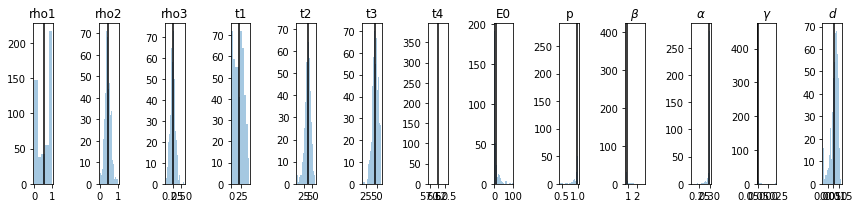

In [5]:
T = S.shape[0]
print("Time series length", T)

f, axarr = plt.subplots(1, theta_hat.shape[1], figsize=(12, 3))
for i in range(theta_hat.shape[1]):
    
    sns.distplot(theta_hat[:, i], ax=axarr[i], kde=False)
    axarr[i].axvline(theta_means[i], color='black')

    axarr[i].set_title(param_names[i])
f.tight_layout()

for i in range(theta_hat.shape[1]):
    print(param_names[i],theta_means[i])

Currently, we have the following parameters:

1. $\alpha$ - inverse of incubation period (rate at which exposed move to infected)
2. $\beta$ - average contact rate in the population (I would model this in a more fine-grained manner
3. $\gamma$ - inverse of the mean infectous period (or rate at which infectious move to recovered)
4. $d$ - death rate
5. $\rho$ - social distancing $\in [0, 1]$

## Plot prediction

d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.01370945067164522
d 0.013709

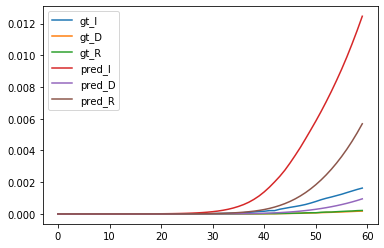

In [6]:

t = np.linspace(0, T, int(T/1) + 1)
x = forward_model(theta_hat_e, t, psteps=50, init_params=[N, 1, 0, 0, 0])
x = add_counting_noise(x, N, theta_hat[:,8:9])


mean_x = np.mean(x,axis=0)

import matplotlib.pyplot as plt

plt.plot(data_x[:,1], label="gt_I")
plt.plot(data_x[:,2], label="gt_D")
plt.plot(data_x[:,3], label="gt_R")

plt.plot(mean_x[:T,1], label="pred_I")
plt.plot(mean_x[:T,2], label="pred_D")
plt.plot(mean_x[:T,3], label="pred_R")
plt.legend()